# Прогноз числа Вульфа (число пятен на Солнце)

***
Постановка задачи
1. Найти и скачать данные по числам Вульфа https://en.wikipedia.org/wiki/Wolf_number .
2. Построить модель, предсказывающую число Вульфа через полгода.
3. Прислать ноутбук, который можно запустить сверху вниз, чтобы считать данные по числам Вульфа с диска, провести с ними нужные манипуляции, обучить модель, получить ее предсказания, вывести график, где предсказания модели будут наложены на фактические наблюдения из отложенной выборки.

Относительное число солнечных пятен $R$ вычисляется по формуле

$R=k(10g+s)$

*где:*
$s$ - количество отдельных пятен,
$g$ - число групп солнечных пятен, и
$k$ - коэффициент, зависящий от обсерватории или персональным коэффициентом уменьшения.

С 1 июля 2015 года применяется пересмотренная и обновленная международная серия чисел солнечных пятен.


Этапы решения

1. [Импорт библиотек подготовка данных](#1)
2. [Преобразование данных](#2)
3. [Модель ARIMA](#3)

## <a id="1"></a>Импорт библиотек подготовка данных

In [3]:
#!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
#установка зависимостей при необходимости
#!pip install -r requirements.txt

In [1]:
import requests
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from math import sqrt
import seaborn as sns



#постоянный адрес источинка
url_wolf_number = "https://www.sidc.be/SILSO/DATA/SN_m_tot_V2.0.txt"
#Source: WDC-SILSO, Royal Observatory of Belgium, Brussels
folder_path = "data"

def loadfile(url_wolf_number, folder_path)->str:
    #создадим функцию загрузчика на диск
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    response = requests.get(url_wolf_number)
    data = response.text
    file_path = os.path.join(folder_path, "SN_m_tot_V2.0.txt.txt")
    with open(file_path, "w") as f:
        f.write(data)
    print("Данные загружены:", file_path)
    return file_path

file_path = loadfile(url_wolf_number, folder_path)

2024-04-15 22:14:23.559808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 22:14:24.715557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Данные загружены: data/SN_m_tot_V2.0.txt.txt


## <a id="2"></a>Преобразование данных

Имя файла: SN_m_tot_V2.0.txt 
Формат: обычный ASCII-текст

Содержание:
- Колонка 1-2: Дата по григорианскому календарю
    - Год
    - Месяц
- Колонка 3: Дата в долях года для середины соответствующего месяца
- Колонка 4: Среднемесячное общее число солнечных пятен.
- Колонка 5: Среднемесячное стандартное отклонение исходных чисел солнечных пятен с отдельных станций.
- Колонка 6: Количество наблюдений, использованных для расчета среднемесячного общего числа солнечных пятен.
- Колонка 7: маркер "окончательное/окончательное". Пробел означает, что значение является окончательным. Символ "*" указывает на то, что месячное значение все еще является предварительным и может быть пересмотрено (обычно в последние 3-6 месяцев).

Формат строки [расположение символов]:
- [1-4] Год
- [6-7] Месяц
- [9-16] Десятичная дата
- [19-23] Месячное общее число солнечных пятен
- [25-29] Стандартное отклонение
- [32-35] Число наблюдений
- [37] Определяющий/окончательный показатель

(c)Source: WDC-SILSO, Royal Observatory of Belgium, Brussels

In [2]:
#определим формат загружаемых данных
columns = ['Year', 'Month', 'DecimalDate', 'SunspotNumber', 'StdDev', 'NumObs', 'DefProv']
dtypes = {'Year': int, 'Month': int, 'DecimalDate': float, 'SunspotNumber': float, 
          'StdDev': float, 'NumObs': int, 'DefProv': str}

df = pd.read_csv(file_path, 
                 delim_whitespace=True, 
                 names=columns,
                 dtype=dtypes,
                 skiprows=0)

In [3]:
df.head(4)

,Year,Month,DecimalDate,SunspotNumber,StdDev,NumObs,DefProv
0,1749,1,1749.042,96.7,-1.0,-1,NaN
1,1749,2,1749.123,104.3,-1.0,-1,NaN
2,1749,3,1749.204,116.7,-1.0,-1,NaN
3,1749,4,1749.288,92.8,-1.0,-1,NaN


In [4]:
# Преобразование в дату
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))

# дату в качестве индекса
df.set_index('Date', inplace=True)
ts = df['SunspotNumber']


       SunspotNumber       StdDev       NumObs
count    3303.000000  3303.000000  3303.000000
mean       81.805813     5.650167   117.584620
std        67.644678     5.303368   249.868685
min         0.000000    -1.000000    -1.000000
25%        24.100000    -1.000000    -1.000000
50%        67.700000     5.400000    30.000000
75%       122.450000     9.500000    31.000000
max       398.200000    29.400000  1587.000000


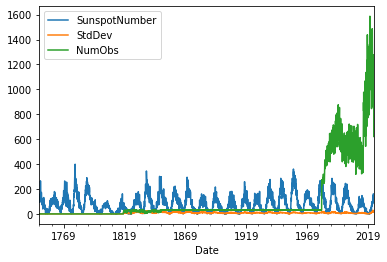

In [5]:
#посмотрим на данные
print(df[["SunspotNumber", "StdDev", "NumObs"]].describe())

df[["SunspotNumber", "StdDev", "NumObs"]].plot()
plt.show()


/miniconda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


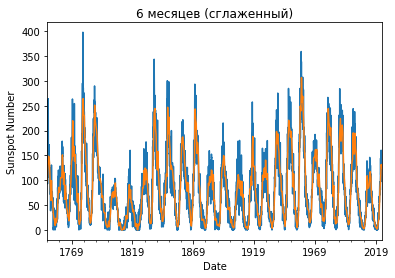

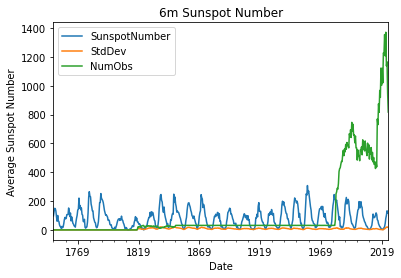

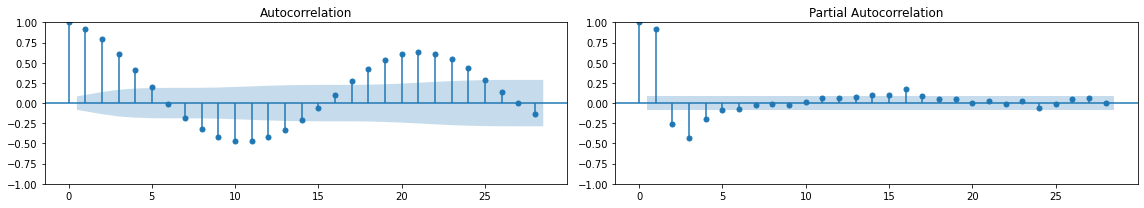

ADF Statistic: -3.2124804252309525
p-value: 0.019273534026245882


In [202]:
forcast_horizont=6 #желаемый горизонт прогноза модели
seasonality = int(11*12/forcast_horizont)#сезонность 11 лет


# Посмотрим на данные
df['SunspotNumber'].plot()
plt.title('Raw Sunspot Number')
plt.ylabel('Sunspot Number')
plt.xlabel('Year')

#построим сглаженный ряд на 6 месячных отерзках 
fast_ts=df['SunspotNumber'][:-forcast_horizont].resample("6M").mean()

# Посмотрим на график
rolmean = fast_ts
rolmean.plot()
plt.title('6 месяцев (сглаженный)')

# построим сглаженные данные на 6 месячных отрезках
annual = df[['SunspotNumber', 'StdDev', 'NumObs']].resample('6M').mean()
annual.plot()
plt.title('6m Sunspot Number')
plt.ylabel('Average Sunspot Number')


# графики 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
plot_acf(fast_ts, ax=ax1)
plot_pacf(fast_ts, ax=ax2)

plt.tight_layout()
plt.show()

# Проверка стационарности
result = adfuller(fast_ts)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


График автокорреляции проявляет несколько лагов с корреляцией, превышающий доверительный интервал, пики в 11 (5,5 лет) и 22 (11 лет), похоже мы имеем дело с временным рядом с яркой сезонностью и эффектом долгой памяти. График частичной автокорреляции показывает, что после удаления влияния более коротких лагов только ближайшее прошлое (до 4 лага) оказывает сильное влияние на текущее наблюдение.

Исходя из этих результатов, с отрицательной статистикой ADF и низким p-значением, есть основания отвергнуть нулевую гипотезу, что указывает на то, что временной ряд является стационарным.

<AxesSubplot:xlabel='Date'>

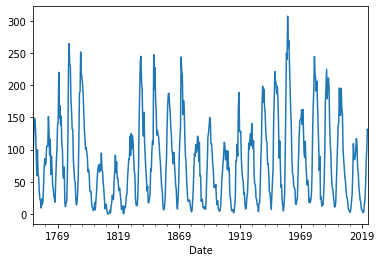

In [115]:
fast_ts.plot()

## <a id="3"></a>Модель ARIMA

In [146]:

# Ищем оптимальные параметры для ARIMA на свежей выборке по сглаженному ряду минус последний период 6 месяцев

model_best = pm.auto_arima(fast_ts[:-3], 
                      start_p=1, 
                      start_q=1, 
                      max_p=30, 
                      max_q=5,
                      m=seasonality, #сезонность 11 лет
                      start_P=0, 
                      seasonal=True, 
                      d=1, 
                      D=1, 
                      trace=True, 
                      n_jobs=-1)

# Лучшие параметры для ARIMA   
model = pm.ARIMA(order=(model_best.order[0],1,model_best.order[1]), 
                  seasonal_order=(model_best.seasonal_order[0],1,model_best.seasonal_order[1],seasonality))


/miniconda/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[22]             : AIC=inf, Time=5.55 sec
 ARIMA(0,1,0)(0,1,0)[22]             : AIC=5180.093, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[22]             : AIC=5056.286, Time=0.77 sec
 ARIMA(0,1,1)(0,1,1)[22]             : AIC=inf, Time=3.39 sec
 ARIMA(1,1,0)(0,1,0)[22]             : AIC=5173.677, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[22]             : AIC=5008.455, Time=7.81 sec
 ARIMA(1,1,0)(2,1,1)[22]             : AIC=inf, Time=42.55 sec
 ARIMA(1,1,0)(1,1,1)[22]             : AIC=inf, Time=2.67 sec
 ARIMA(0,1,0)(2,1,0)[22]             : AIC=5006.545, Time=5.80 sec
 ARIMA(0,1,0)(1,1,0)[22]             : AIC=5054.927, Time=0.54 sec
 ARIMA(0,1,0)(2,1,1)[22]             : AIC=inf, Time=73.45 sec
 ARIMA(0,1,0)(1,1,1)[22]             : AIC=inf, Time=3.92 sec
 ARIMA(0,1,1)(2,1,0)[22]             : AIC=5008.485, Time=8.05 sec
 ARIMA(1,1,1)(2,1,0)[22]             : AIC=5004.019, Time=19.43 sec
 ARIMA(1,1,1)(1,1,0)[22]             : AIC=504

In [183]:
model.fit(fast_ts[:-2])#для большей глубины на графике отступим 1,5 года и обучим модель

ARIMA(order=(2, 1, 0), seasonal_order=(2, 1, 0, 22))

                    0      Lower       Upper
2023-01-31  89.941070  37.594358  142.287783
2023-07-31  65.202687   0.000000  138.996593
2024-01-31  83.619937   0.000000  181.504233
2024-07-31  79.426749   0.000000  196.460916


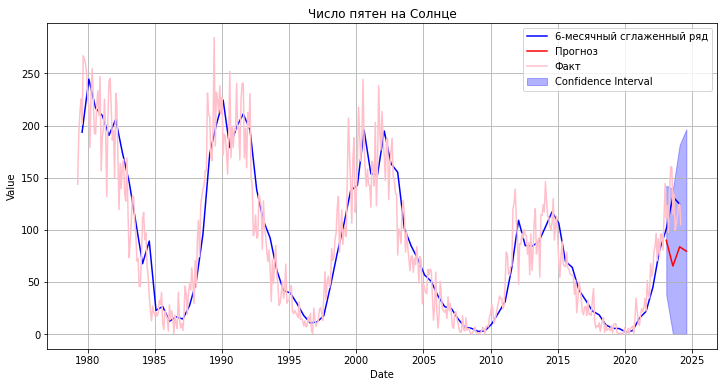

In [195]:
# делаем прогноз на 2 года вперед
n_periods = 4
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)
index_of_fc = fc.index #np.arange(len(fast_ts)-1, len(fast_ts)-1+n_periods)
stderr = df['SunspotNumber'].std()
# Convert forecast to DataFrame  
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

forecast = pd.DataFrame(fc_series)
forecast['Lower'] = lower_series
forecast['Upper'] = upper_series
forecast[forecast<0]=0

print(forecast)

plot_interval = 90 #глубина графика
plt.figure(figsize=(12, 6))
plt.plot(fast_ts.index[-plot_interval:], fast_ts[-plot_interval:], label='6-месячный сглаженный ряд', color='blue')
plt.plot(fc_series.index, fc_series, label='Прогноз', color='red')
plt.plot(df['SunspotNumber'][-plot_interval*6:],  label='Факт', color='pink')
plt.fill_between(forecast.index, forecast['Lower'], forecast['Upper'], color='blue', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Число пятен на Солнце')
plt.legend()
plt.grid(True)
plt.show()
